In [14]:
import os
import cv2
import math
import kornia
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch

### IPM Class

In [15]:
def draw_box(ax, corners, color):
    point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2], corners[:, 0]])
    ax.plot(point_squence.T[0], point_squence.T[1], color=color)
    
def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return torch.tensor([qx, qy])


class BEV():
    
    def __init__( self, data_root, scene_id, sample_id, ipm_params ):
        self.data_root = data_root
        self.scene_id = scene_id
        self.sample_id = sample_id
        self.ipm_params = ipm_params
        self.bevs = self._getBEV()
        self.combined_bev = self._combine()
        
    def _getBEV( self ):
        bevs = {}
        for view in self.ipm_params:
            path = os.path.join(data_root, 'scene_%d' % scene_id, 'sample_%d' % sample_id, 'CAM_%s.jpeg'%view)
            points_src, points_dst = ipm_params[view]
            bevs[view] = _BEV( path, points_src, points_dst )
        return bevs
        
    def _combine( self ):
        out = None
        priority_queue = ['FRONT','BACK','FRONT_LEFT','FRONT_RIGHT','BACK_LEFT','BACK_RIGHT']
        for view in priority_queue:
            if view in self.bevs:
                if out is None:
                    out = self.bevs[view].dst_img.copy()
                else:
                    new_layer = self.bevs[view].dst_img
                    mask = (out.sum(2) == 0).astype(np.uint8)
                    mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
                    out += new_layer * mask
        return out
    
    def visualize( self, view = None, anno_path = 'data/annotation.csv' ):
        
        corner_names = ['fl_x', 'fr_x', 'bl_x', 'br_x', 'fl_y', 'fr_y','bl_y', 'br_y']
        colors = ['c', 'r', 'b', 'g']

        # Get target
        anno = pd.read_csv( anno_path )
        data_entries = anno[(anno['scene']==self.scene_id)\
            & (anno['sample']==self.sample_id)]
        corners = data_entries[corner_names].to_numpy()
        targets = data_entries['category_id'].values.tolist()
        
        corners = torch.tensor(
            data_entries[corner_names].to_numpy(), dtype=torch.float).view(-1, 2, 4)
        corners[:, 0, :] = corners[:, 0, :] * 10 + 400
        corners[:, 1, :] = -corners[:, 1, :] * 10 + 400

        # Rotate
        for i in range(len(corners)):
            for j in range(4):
                corners[i, :, j] = rotate((400, 400), corners[i, :, j], -math.pi / 2)
        
        if view is not None:
            src_img = self.bevs[view].src_img
            dst_img = self.bevs[view].dst_img

            # Visualization
            fig, axs = plt.subplots(1, 2, figsize=(20, 15))
            axs = axs.ravel()

            axs[0].set_title('image source')
            axs[0].imshow(src_img)

            axs[1].set_title('image destination')
            axs[1].imshow(dst_img)
            axs[1].plot(400, 400, 'x', color='red')
            color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']
            #print(targets)
            for i, bb in enumerate(corners):
                draw_box(axs[1], bb, color=color_list[targets[i]])
                x,y = bb.mean(dim = 1).numpy()
                plt.text(x, y, '(%s,%s)'%(str(round(x,2)),str(round(y,2))), color=color_list[targets[i]])
 
            points_src, points_dst = ipm_params[view]
            for i in range(points_src.size(1)):
                axs[0].scatter(points_src[0, i, 0], points_src[0, i, 1], color=colors[i])
                axs[1].scatter(points_dst[0, i, 0], points_dst[0, i, 1], color=colors[i])
                
        else:
            fig, axs = plt.subplots(figsize=(12, 12))
            axs.imshow(self.combined_bev)
            #print(targets)
            axs.plot(400, 400, 'x', color='red')
            color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']
            for i, bb in enumerate(corners):
                draw_box(axs, bb, color=color_list[targets[i]])
                x,y = bb.mean(dim = 1).numpy()
                plt.text(x, y, '(%s,%s)'%(str(round(x,2)),str(round(y,2))), color=color_list[targets[i]])
                
                
    def save ( self, path, view = None ):
        if view is not None:
            plt.imsave( path, self.bevs[view].dst_img) 
        else:
            plt.imsave( path, self.combined_bev.transpose(2,0,1).swapaxes(-2,-1)[...,::-1].transpose(1,2,0))
    
    
class _BEV():
    
    def __init__( self, path, points_src, points_dst ):
        self.path =  path
        self.points_src = points_src 
        self.points_dst = points_dst
        self.src_img =  self._read()
        self.dst_img = self._convert()
    
    def _read( self ):
        return cv2.cvtColor( cv2.imread( self.path ) , cv2.COLOR_BGR2RGB )
    

    def _convert( self ):
        
        src_img = kornia.image_to_tensor( self.src_img, keepdim = False )
        
        dst_h, dst_w = 800, 800

        # Compute perspective transform
        M = kornia.get_perspective_transform(self.points_src, self.points_dst)


        # Image to BEV transformation
        dst_img = kornia.warp_perspective(
            src_img.float(), M, dsize=(dst_h, dst_w), flags='bilinear', border_mode='zeros')
        
        # remove unwanted portion of BEV image. e.g for FRONT view dst point should not be higher than 450.
        if 'FRONT' in self.path:
            dst_img[:, :, 400:, :] = 0

        if 'BACK' in self.path:
            dst_img[:, :, :400, :] = 0

        if 'LEFT' in self.path:
            dst_img[:, :, :, 400:] = 0

        if 'RIGHT' in self.path:
            dst_img[:, :, :, :400] = 0
            
        dst_img = kornia.tensor_to_image(dst_img.byte())
        return dst_img
        

In [16]:
ipm_params = {
    # calibrated using SCENE 111 SAMPLE 11 image
    'FRONT': ( torch.tensor([[ [100.,180.], [123.,163.], [267., 170.], [207., 143.],]]),
                    torch.tensor([[[389, 323], [389, 284], [442, 305.], [461,74.],]])),


    # calibrated using SCENE 124 SAMPLE 0 FRONT_RIGHT image
    'FRONT_RIGHT': ( torch.tensor([[[82., 191.], [125., 174.], [257,219.], [264.,190.],]]),
                   torch.tensor([[[438., 342.], [455., 342.], [440, 389], [455, 390],]]) ),
    
    # calibrated using SCENE 124 SAMPLE 0 FRONT_RIGHT image
    'BACK_RIGHT': ( torch.tensor([[[31., 191.], [34., 221.], [188,169.], [229.,183.],]]),
                   torch.tensor([[[456., 405.], [440., 405.], [460, 460], [441, 460],]]) ),
    
    # calibrated using SCENE 126 SAMPLE 70 FRONT_LEFT image
    'FRONT_LEFT': ( torch.tensor([[[228., 191.], [52., 219.], [202, 174.], [44.,192.],]]),
                   torch.tensor([[[368., 345.], [367., 420.], [348, 345], [347, 420],]]) ),
    
    # calibrated using SCENE 110 SAMPLE 6 BACK_LEFT image
    'BACK_LEFT': ( torch.tensor([[[273., 208.], [274., 190.], [48.,170], [94.,166.],]]),
                   torch.tensor([[[358., 400.], [345., 400.], [358, 511],[345, 511], ]]) ),
    
    
    # calibrated using SCENE 111 SAMPLE 28 image
    'BACK': ( torch.tensor([[[32., 153.], [192., 167.], [179.,153.], [93,135],]]),
                   torch.tensor([[[464.,540], [391., 484.], [391.,525],[490,769]]]) ),

}

#### Visualization

In [17]:
os.getcwd()

'/Users/shutinggu/Desktop/DL/code'

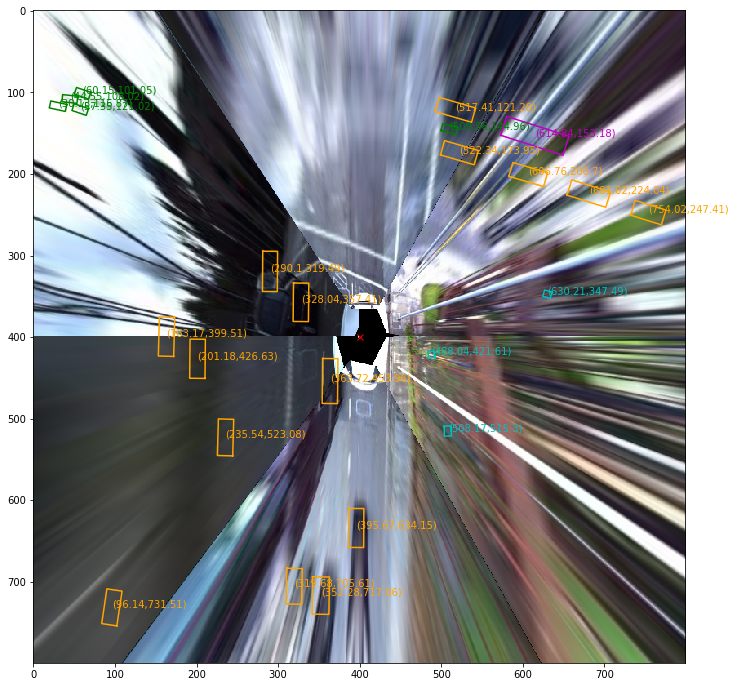

In [18]:
data_root = 'data'

scene_id = 111
sample_id = 11
bev = BEV( data_root, scene_id, sample_id, ipm_params )

# This shows the combined BEV
bev.visualize()

# # can also see specific view
# bev.visualize( view = 'FRONT')

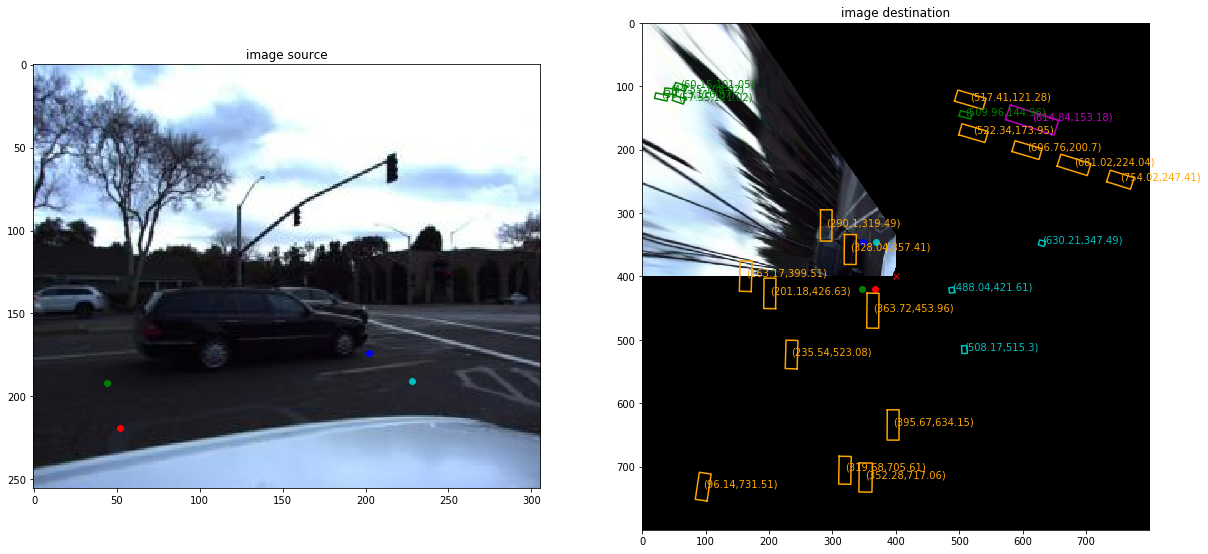

In [19]:
bev.visualize(view='FRONT_LEFT')

#### Save BEV

In [20]:
# save the combined BEV
bev.save('./BEV/testBEV.jpg')
# can also save BEV by view
bev.save('./BEV/testBEV_FRONT.jpg', view = 'FRONT')

In [22]:
data_root = 'data'

for scene_id in np.arange(106, 134):
    for sample_id in np.arange(126):
        bev = BEV( data_root, scene_id, sample_id, ipm_params )

        bev.save('./BEV/{0}_{1}.jpg'.format(scene_id, sample_id))

#### Save Roadmap

In [72]:
from helper import convert_map_to_lane_map, convert_map_to_road_map
import torchvision

In [78]:
image_folder = 'data'
for scene_id in np.arange(106, 134):
    for sample_id in np.arange(126):
        ego_path = os.path.join(data_root, 'scene_%d' % scene_id, 'sample_%d' % sample_id, 'ego.png')
#         ego_path = os.path.join(sample_path, 'ego.png')
        ego_image = Image.open(ego_path)
        ego_image = torchvision.transforms.functional.to_tensor(ego_image)
        road_image = convert_map_to_road_map(ego_image)
        
        plt.imsave( './data_bev/masks/{0}_{1}.jpeg'.format(scene_id, sample_id), road_image)
            